## Table of contents
- [1- Problem](#1)
- [2- imports](#2)
- [3- dataset information](#3)
- [4- data visualization](#4)
- [5- data preprocessing](#5)
- [6- model](#6)
- [7- predictions](#7)

<a name='1'></a>
# 1- problem
Music. Experts have been trying for a long time to understand sound and what differenciates one song from another. How to visualize sound. What makes a tone different from another.
This data hopefully can give the opportunity to do just that.

**contents:<br />**
genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.
2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

<a name='2'></a>
# 2- imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA

import librosa, IPython
import librosa.display as lplt

2021-09-12 20:22:11.074477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


<a name='3'></a>
# 3- dataset information

read the 3 seconds CSV file

In [2]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [3]:
df.shape

(9990, 60)

null values

In [4]:
df.isnull().sum().sum()

0

duplicated rows

In [5]:
df.duplicated().sum()

0

dataFrame information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

dataFrame's columns correlation

In [7]:
df.corr()

length  chroma_stft_mean  chroma_stft_var  rms_mean  \
length                      NaN               NaN              NaN       NaN   
chroma_stft_mean            NaN          1.000000        -0.443757  0.424706   
chroma_stft_var             NaN         -0.443757         1.000000 -0.078410   
rms_mean                    NaN          0.424706        -0.078410  1.000000   
rms_var                     NaN          0.243647         0.251900  0.553770   
spectral_centroid_mean      NaN          0.534670        -0.208136  0.470781   
spectral_centroid_var       NaN          0.251985         0.276964  0.241796   
spectral_bandwidth_mean     NaN          0.464617        -0.031197  0.495142   
spectral_bandwidth_var      NaN          0.100909         0.291007  0.085760   
rolloff_mean                NaN          0.526881        -0.141792  0.500178   
rolloff_var                 NaN          0.138394         0.330930  0.157281   
zero_crossing_rate_mean     NaN          0.457080        -0.391281  0.293745   
zero_crossing_rate_var      NaN          0.278017         0.138214  0.217606   
harmony_mean                NaN          0.034305        -0.010949  0.065134   
harmony_var                 NaN          0.216488         0.024139  0.884846   
perceptr_mean               NaN         -0.109303         0.072719 -0.012401   
perceptr_var                NaN          0.417177         0.000478  0.766446   
tempo                       NaN          0.019084        -0.004419  0.015668   
mfcc1_mean                  NaN          0.573974        -0.296517  0.795000   
mfcc1_var                   NaN          0.054769         0.347460 -0.080320   
mfcc2_mean                  NaN         -0.513978         0.091757 -0.453606   
mfcc2_var                   NaN          0.055816         0.326217  0.033635   
mfcc3_mean                  NaN          0.013981         0.323529  0.136936   
mfcc3_var                   NaN          0.121196         0.354501  0.069158   
mfcc4_mean                  NaN          0.213522        -0.194552 -0.034473   
mfcc4_var                   NaN          0.135822         0.333186  0.178296   
mfcc5_mean                  NaN          0.069027         0.248247  0.122941   
mfcc5_var                   NaN          0.090913         0.351826  0.119419   
mfcc6_mean                  NaN          0.342903        -0.155817  0.072916   
mfcc6_var                   NaN          0.121105         0.363150  0.212010   
mfcc7_mean                  NaN          0.112848         0.192922  0.181207   
mfcc7_var                   NaN          0.101439         0.343599  0.140892   
mfcc8_mean                  NaN          0.423220        -0.239743  0.134868   
mfcc8_var                   NaN          0.032791         0.352686  0.126329   
mfcc9_mean                  NaN          0.155357         0.126653  0.213195   
mfcc9_var                   NaN         -0.016019         0.363827  0.087181   
mfcc10_mean                 NaN          0.376734        -0.216207  0.144650   
mfcc10_var                  NaN         -0.067534         0.337400  0.070977   
mfcc11_mean                 NaN          0.108459         0.149261  0.133593   
mfcc11_var                  NaN         -0.147130         0.335556 -0.012006   
mfcc12_mean                 NaN          0.400529        -0.263772  0.134779   
mfcc12_var                  NaN         -0.226017         0.302924 -0.064247   
mfcc13_mean                 NaN         -0.036171         0.209318  0.043769   
mfcc13_var                  NaN         -0.242423         0.309993 -0.088406   
mfcc14_mean                 NaN          0.297993        -0.197412  0.113960   
mfcc14_var                  NaN         -0.265843         0.283260 -0.080352   
mfcc15_mean                 NaN         -0.078784         0.162830  0.012184   
mfcc15_var                  NaN         -0.270092         0.285569 -0.088842   
mfcc16_mean                 NaN          0.228293        -0.221620  0.055563   
mfcc16_var               

plot the correlations

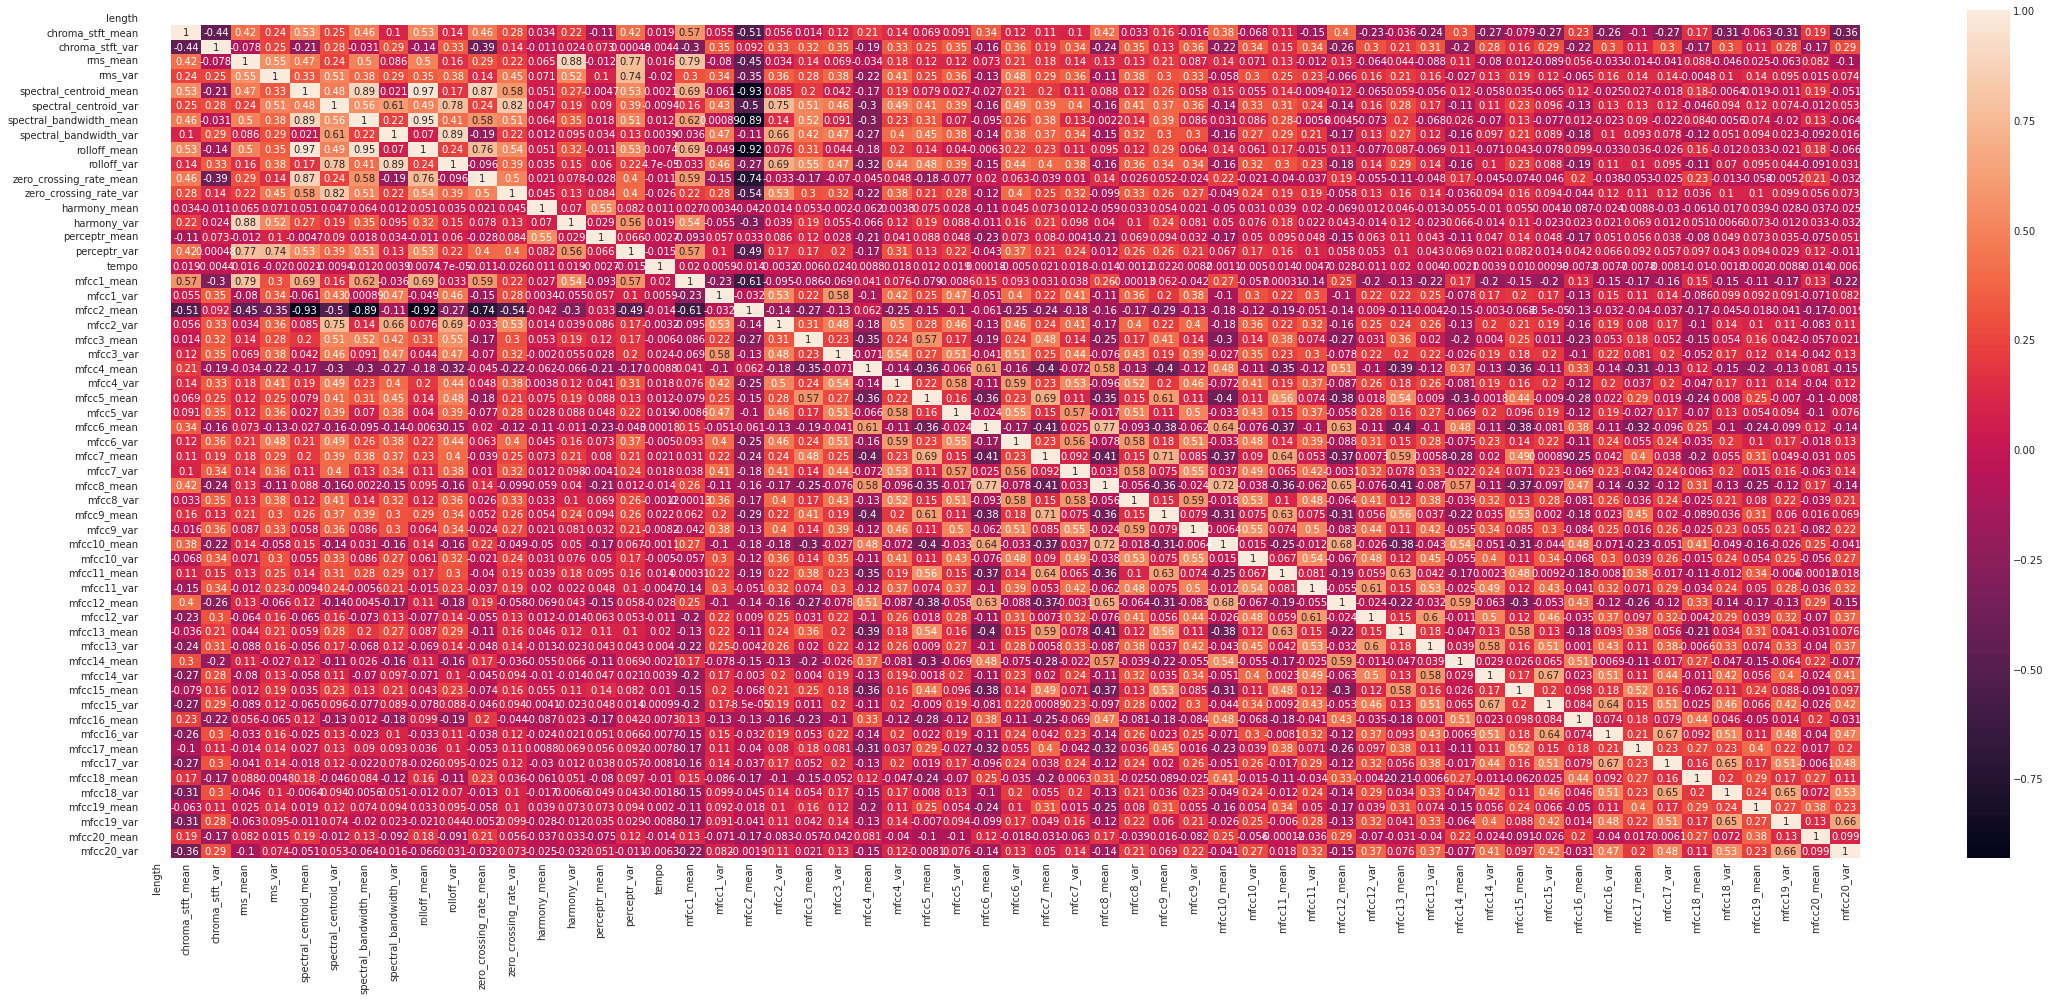

In [8]:
plt.figure(figsize=(32, 14))

heatmap = sns.heatmap(df.corr(), annot=True)

plot the corrs in a better way

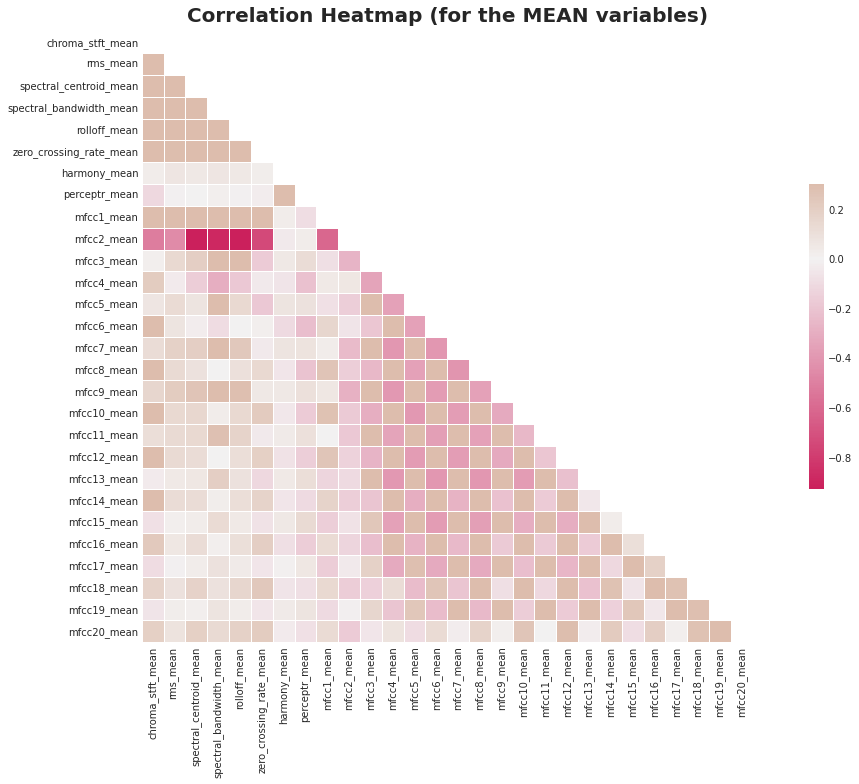

In [9]:
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11));

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

In [10]:
df.label.value_counts().reset_index()

index  label
0     reggae   1000
1        pop   1000
2      blues   1000
3       jazz   1000
4      metal   1000
5      disco    999
6       rock    998
7  classical    998
8     hiphop    998
9    country    997

<a name='4'></a>
# 4- Data visualization

loading one audio example in time series using librosa

In [11]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

time of the song

In [12]:
audio_data.shape[0]/sr

30.081632653061224

play the song!

In [13]:
IPython.display.Audio(audio_data, rate=sr)

wave plot of this country song

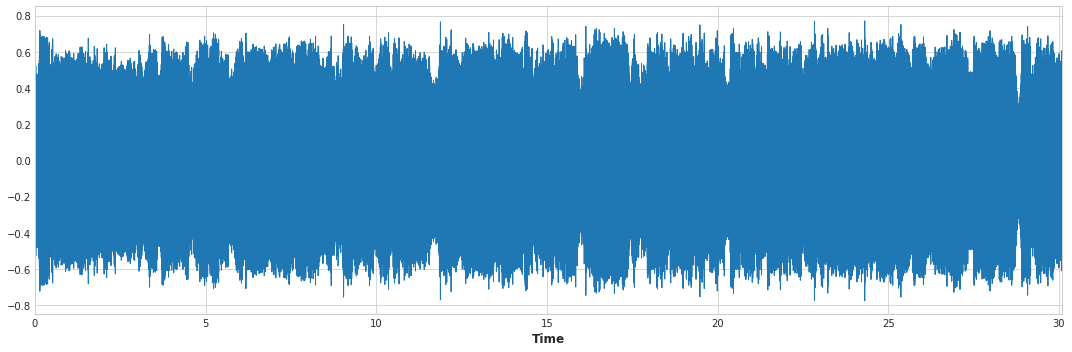

In [14]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

plot zoomed audio wave

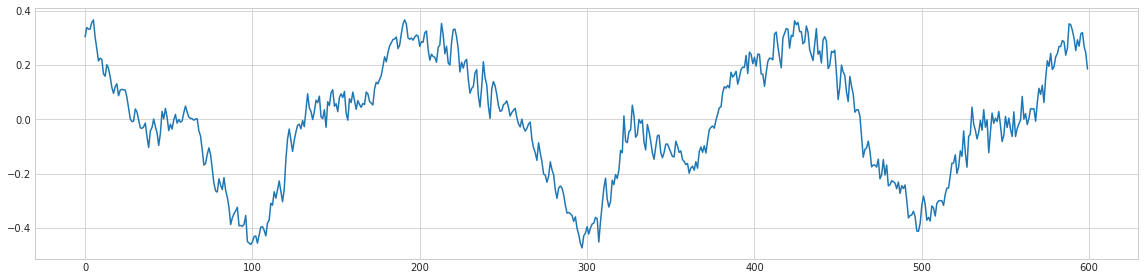

In [15]:
plt.figure(figsize=(16,4))
plt.plot(audio_data[1200:1800])
plt.show()

plot Spectrogram with amplitude and decibel log using librosa.stft

/opt/conda/lib/python3.7/site-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


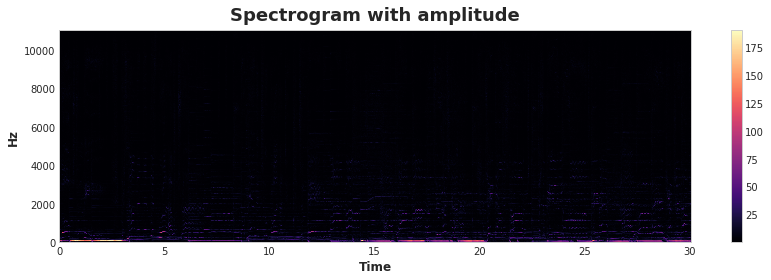

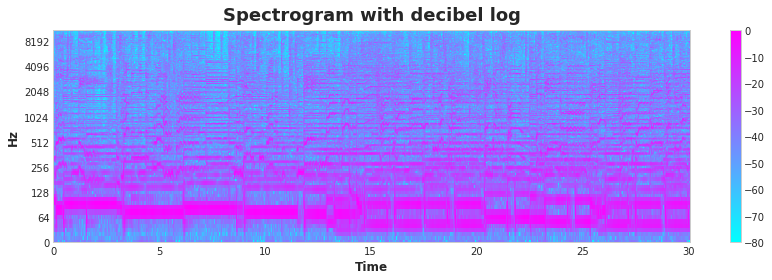

In [16]:
n_fft = 2048
hop_length = 512

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

plot mel spectrogram

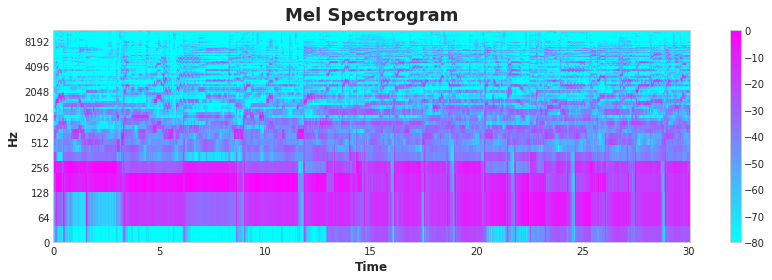

In [17]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(12,4))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

plot chroma Features

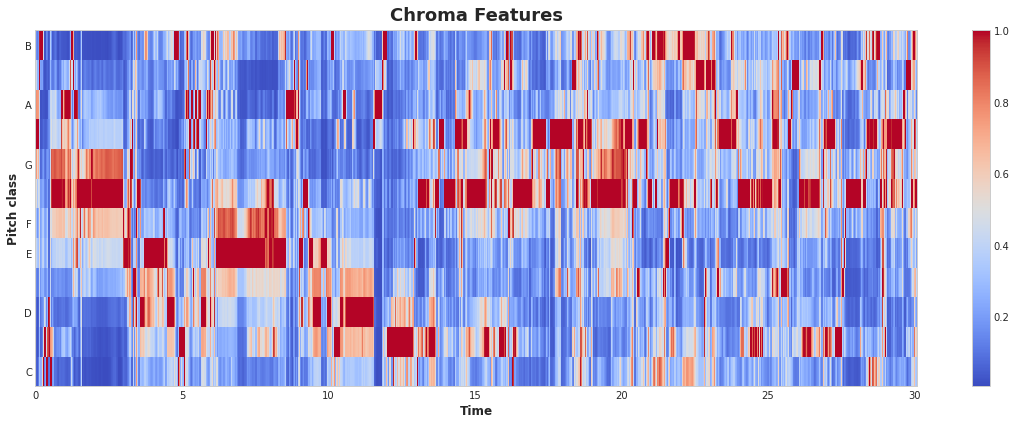

In [18]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

**PCA on genres**

In [19]:
data = df.iloc[:, 1:]

In [20]:
y = data['label']
X = data.loc[:, data.columns != 'label']

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
x_st = min_max_scaler.fit_transform(X)

In [22]:
X = pd.DataFrame(x_st, columns=X.columns)
X.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0     0.0          0.355399         0.716757  0.293133  0.107955   
1     0.0          0.367322         0.670347  0.253040  0.044447   
2     0.0          0.373159         0.728067  0.296753  0.141663   
3     0.0          0.399349         0.677066  0.298024  0.075042   
4     0.0          0.355668         0.689113  0.322308  0.052149   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                0.262173               0.034784                 0.459205   
1                0.270969               0.018716                 0.470831   
2                0.265293               0.023073                 0.494051   
3                0.238427               0.023187                 0.455246   
4                0.233460               0.016451                 0.451651   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0                0.094130      0.346153  ...     0.363613    0.056198   
1                0.052261      0.363722  ...     0.468596    0.092912   
2                0.059922      0.378215  ...     0.479681    0.096704   
3                0.066234      0.329587  ...     0.386258    0.067995   
4                0.047830      0.318453  ...     0.438567    0.042500   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     0.397172    0.066062     0.371828    0.055344     0.380831    0.026797   
1     0.351681    0.074001     0.362068    0.076365     0.418452    0.082414   
2     0.420979    0.050639     0.400536    0.067509     0.433742    0.043841   
3     0.387474    0.050617     0.380430    0.050030     0.405824    0.041898   
4     0.460314    0.083860     0.388590    0.076524     0.409019    0.020763   

   mfcc20_mean  mfcc20_var  
0     0.506746    0.047781  
1     0.593029    0.065548  
2     0.546264    0.036062  
3     0.562204    0.034873  
4     0.517913    0.031713  

[5 rows x 58 columns]

In [23]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [24]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [25]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

pc1       pc2  label
0 -0.242167 -0.121147  blues
1 -0.276062 -0.230291  blues
2 -0.190024 -0.119509  blues
3 -0.278550 -0.167689  blues
4 -0.309771 -0.187990  blues

Text(0, 0.5, 'Principal Component 2')

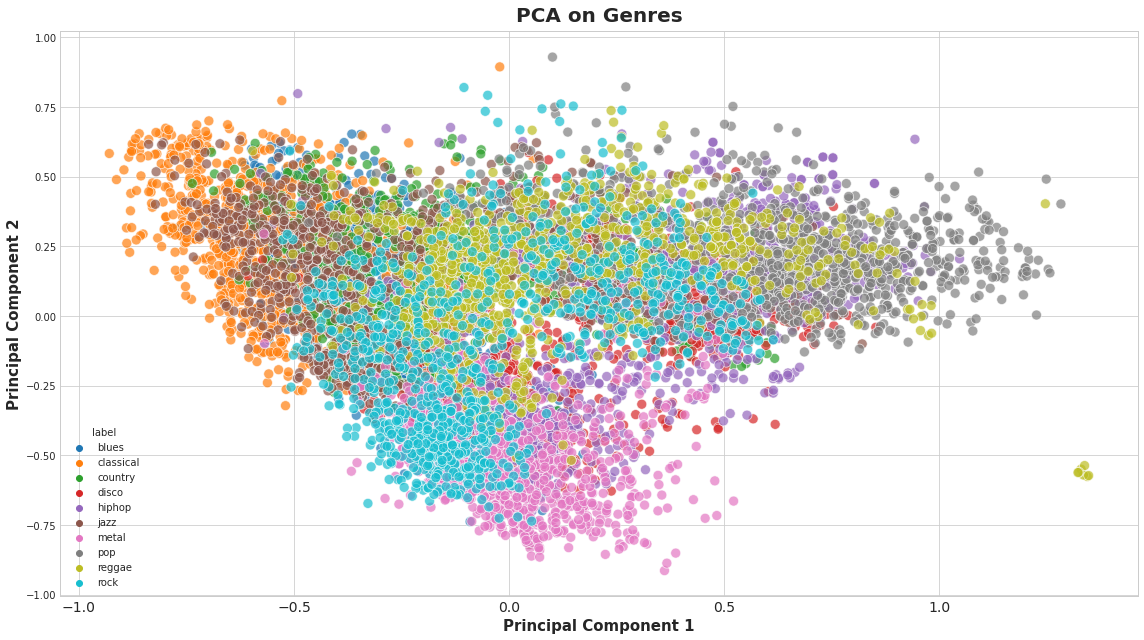

In [26]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

<a name='5'></a>
# 5- Data preprocessing

dicts of labels and indices

In [27]:
label_to_index = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
index_to_label = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

replace the labels with indices and create our target dataFrame

In [28]:
df['label'].replace(label_to_index, inplace=True)

In [29]:
stay = ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']
df.drop(columns=stay, inplace=True)
df.head()

filename  label
0  blues.00000.0.wav      0
1  blues.00000.1.wav      0
2  blues.00000.2.wav      0
3  blues.00000.3.wav      0
4  blues.00000.4.wav      0

getting the **mfcc** of each audio, so our model should fit and predict on those data

In [30]:
total_samples = 29 * sr
sample_per_slice = int(total_samples / 10)

In [31]:
source_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/'
labels = []
mfcc_lst = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
    for file in filenames:
        if os.path.join(dirpath, file) != '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':
            audio, sr = librosa.load(os.path.join(dirpath, file), duration=29)
            for s in range(10):
                start_sample = sample_per_slice * s
                end_sample = start_sample + sample_per_slice
                mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample], sr=sr, n_mfcc=15)
                mfcc = mfcc.T
                labels.append(i-1)
                mfcc_lst.append(mfcc.tolist())
        else:
            pass

convert to numpy arrays

In [32]:
X = np.array(mfcc_lst)
y = np.array(labels)

In [33]:
# base_path = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
# def mel(path):
#     path = path[:-6]+path[-4:]
#     if(path=="jazz.00054.wav"):
#         return
#     first_dot = path.find('.')
#     audio, sr = librosa.load(base_path+ path[:first_dot]+'/' +path)
#     audio, _ = librosa.effects.trim(audio)
#     mfcc = librosa.feature.mfcc(audio[:600000],sr = sr,n_fft = n_fft,hop_length = hop_length)
#     return mfcc

split the dataset

In [34]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(X,y, test_size=0.25, random_state=42)

In [35]:
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]

In [36]:
print('the shape of training set is: ',x_train.shape)
print('the shape of validation set is: ',x_val.shape)

the shape of training set is:  (7492, 125, 15, 1)
the shape of validation set is:  (2498, 125, 15, 1)


In [37]:
# model = tf.keras.models.Sequential([

#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)),
#     tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
#     tf.keras.layers.BatchNormalization(),

#     tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
#     tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'), 
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

<a name='6'></a>
# 6- Model

design model

In [38]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (x_train.shape[1], x_train.shape[2], 1)))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation = 'softmax'))

2021-09-12 20:25:11.567382: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-12 20:25:11.570748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-12 20:25:11.620451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 20:25:11.621106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-12 20:25:11.621200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-12 20:25:11.649422: I tensorflow/stream_executor/platform/def

compile model with adam optimizer and sparse_categorical_crossentropy loss function

In [39]:
model.compile(
optimizer=tf.keras.optimizers.Adam(1e-3),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'],
)

summary of model

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 15, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 15, 16)       2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 15, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 8, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 8, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 8, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 8, 32)         9

define some callbacks

In [41]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

fit the model during 60 epochs, with batch_size equal to 32

In [42]:
epochs = 60

history = model.fit(
    x_train,y_train, epochs=epochs, callbacks=callbacks, batch_size=32,
    validation_data= (x_val,y_val),
)

2021-09-12 20:25:15.047227: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-12 20:25:15.059858: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/60


2021-09-12 20:25:16.531534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-12 20:25:17.365674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-12 20:25:17.392185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


235/235 [==============================] - 10s 11ms/step - loss: 2.7192 - accuracy: 0.2009 - val_loss: 2.5448 - val_accuracy: 0.2198
Epoch 2/60
235/235 [==============================] - 2s 8ms/step - loss: 1.8728 - accuracy: 0.3424 - val_loss: 2.4253 - val_accuracy: 0.3611
Epoch 3/60
235/235 [==============================] - 2s 8ms/step - loss: 1.6235 - accuracy: 0.4183 - val_loss: 2.1285 - val_accuracy: 0.3715
Epoch 4/60
235/235 [==============================] - 2s 8ms/step - loss: 1.5053 - accuracy: 0.4623 - val_loss: 1.3439 - val_accuracy: 0.5240
Epoch 5/60
235/235 [==============================] - 2s 8ms/step - loss: 1.4190 - accuracy: 0.4935 - val_loss: 1.4757 - val_accuracy: 0.4648
Epoch 6/60
235/235 [==============================] - 2s 8ms/step - loss: 1.3368 - accuracy: 0.5144 - val_loss: 1.3958 - val_accuracy: 0.5000
Epoch 7/60
235/235 [==============================] - 2s 8ms/step - loss: 1.2520 - accuracy: 0.5599 - val_loss: 1.0853 - val_accuracy: 0.6121
Epoch 8/60
235/

save the best model

In [43]:
model.load_weights('save_model.h5')

plot some plots of losses and accuracies

<AxesSubplot:>

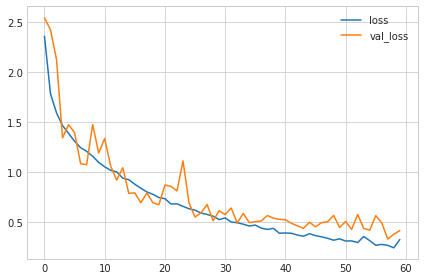

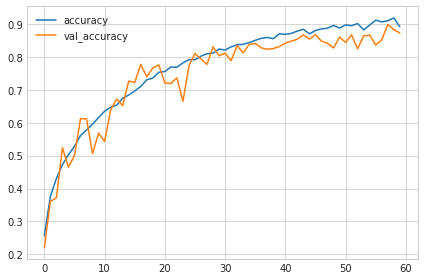

In [44]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

evaluate the model

In [45]:
model.evaluate(x_val,y_val)

79/79 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8987


[0.32976916432380676, 0.8987189531326294]

so its 90% accuracy on the validation set

<a name='7'></a>
# 7- predictions

In [46]:
predicts = model.predict(x_val)

In [47]:
label_preds = np.argmax(predicts,axis = 1)

In [48]:
label_preds

array([4, 5, 0, ..., 9, 7, 8])

**confusion matrix**

In [49]:
genres = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

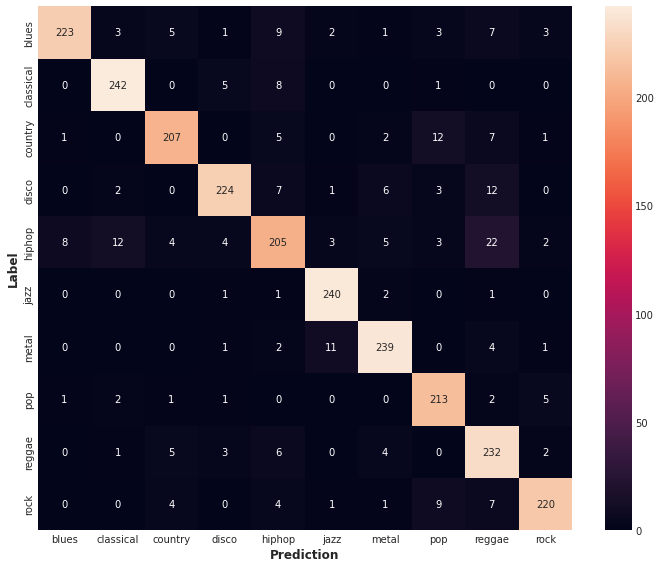

In [50]:
confusion_mtx = tf.math.confusion_matrix(y_val, label_preds) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=genres, yticklabels=genres, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **NICE!**